# Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
import time
from scipy.interpolate import PchipInterpolator
import scipy
from tqdm import tqdm
from collections import defaultdict

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from itertools import chain

import os

# Data

In [3]:
dir_path = "../files/data/TWIN/BH/CLEANED"
csv_files = [f for f in os.listdir(dir_path) if f.endswith(".csv")]
len(csv_files)

5

In [16]:
df = pd.read_csv("../files/data/TWIN/BH/CLEANED/{}".format(csv_files[0]), index_col=False)
df = df[(df['a1/t'] < 1) & (df['a2/t'] < 1)]

for csv_index in csv_files[1:]:
    df_ = pd.read_csv("../files/data/TWIN/BH/CLEANED/{}".format(csv_index), index_col=False)
    df_ = df_[(df_['a1/t'] < 1) & (df_['a2/t'] < 1)]
    df = pd.concat([df, df_], axis=0, ignore_index=True)

df

,c_index,W/R,a1/c1,a1/t,a2/c2,a2/t,r/t,b/t,phi_1,phi_2,K1-T,K2-T,K1-B,K2-B,K1-P,K2-P
0,1.0,500.0,0.1,0.10,0.1,0.10,0.2,1.0,0.057913,0.057913,1.624828,1.623916,1.626950,1.626950,1.867769,1.866769
1,1.0,500.0,0.1,0.10,0.1,0.10,0.2,1.0,0.069369,0.069369,1.652637,1.652641,1.654669,1.653728,1.909001,1.908001
2,1.0,500.0,0.1,0.10,0.1,0.10,0.2,1.0,0.080826,0.080826,1.687232,1.687232,1.686891,1.686707,1.957479,1.956479
3,1.0,500.0,0.1,0.10,0.1,0.10,0.2,1.0,0.092282,0.092282,1.726211,1.726211,1.724012,1.723377,2.011567,2.010567
4,1.0,500.0,0.1,0.10,0.1,0.10,0.2,1.0,0.103739,0.103739,1.767946,1.767946,1.763685,1.763014,2.069387,2.068387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215995,23206.0,100.0,10.0,0.95,10.0,0.95,1.0,1.0,1.467061,1.467061,2.226477,2.226477,-1.263287,-1.263287,55.865238,55.865238
9215996,23206.0,100.0,10.0,0.95,10.0,0.95,1.0,1.0,1.478518,1.478518,2.179056,2.179056,-1.238429,-1.238429,54.674646,54.674646
9215997,23206.0,100.0,10.0,0.95,10.0,0.95,1.0,1.0,1.489974,1.489974,2.135319,2.135319,-1.215566,-1.215566,53.578979,53.578979
9215998,23206.0,100.0,10.0,0.95,10.0,0.95,1.0,1.0,1.501431,1.501431,2.095698,2.095698,-1.195270,-1.195270,52.616988,52.616988


In [17]:
# Get unique combinations of the first four columns
CC_combinations = df.iloc[:, 1:8].drop_duplicates().to_numpy()

print(len(CC_combinations))

72000


In [18]:
print("Different W/r values: ", np.unique(CC_combinations[:,0], axis=0))
print("Different a1/c1 values: ", np.unique(CC_combinations[:,1], axis=0))
print("Different a1/t values: ", np.unique(CC_combinations[:,2], axis=0))
print("Different a2/c2 values: ", np.unique(CC_combinations[:,3], axis=0))
print("Different a2/t values: ", np.unique(CC_combinations[:,4], axis=0))
print("Different r/t values: ", np.unique(CC_combinations[:,5], axis=0))
print("Different b/t values: ", np.unique(CC_combinations[:,6], axis=0))

Different W/r values:  [ 33.333  50.    100.    200.    500.   ]
Different a1/c1 values:  [ 0.1     0.125   0.1667  0.25    0.5     0.75    1.      2.      4.
  6.      8.     10.    ]
Different a1/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different a2/c2 values:  [ 0.1     0.125   0.1667  0.25    0.5     0.75    1.      2.      4.
  6.      8.     10.    ]
Different a2/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [0.2 0.5 1.  2.  3. ]
Different b/t values:  [1.]


In [19]:
df.to_csv("../files/data/FINAL_CSV/TWIN_CORNER_CRACK_BH_QUARTER_ELLIPSE.csv", index=False)

# Data Viz

In [3]:
df = pd.read_csv("../files/data/FINAL_CSV/TWIN/TWIN_CORNER_CRACK_BH_QUARTER_ELLIPSE.csv")
df

,c_index,W/R,a1/c1,a1/t,a2/c2,a2/t,r/t,b/t,phi_1,phi_2,K1-T,K2-T,K1-B,K2-B,K1-P,K2-P
0,1.0,500.0,0.1,0.10,0.1,0.10,0.2,1.0,0.057913,0.057913,1.624828,1.623916,1.626950,1.626950,1.867769,1.866769
1,1.0,500.0,0.1,0.10,0.1,0.10,0.2,1.0,0.069369,0.069369,1.652637,1.652641,1.654669,1.653728,1.909001,1.908001
2,1.0,500.0,0.1,0.10,0.1,0.10,0.2,1.0,0.080826,0.080826,1.687232,1.687232,1.686891,1.686707,1.957479,1.956479
3,1.0,500.0,0.1,0.10,0.1,0.10,0.2,1.0,0.092282,0.092282,1.726211,1.726211,1.724012,1.723377,2.011567,2.010567
4,1.0,500.0,0.1,0.10,0.1,0.10,0.2,1.0,0.103739,0.103739,1.767946,1.767946,1.763685,1.763014,2.069387,2.068387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215995,23206.0,100.0,10.0,0.95,10.0,0.95,1.0,1.0,1.467061,1.467061,2.226477,2.226477,-1.263287,-1.263287,55.865238,55.865238
9215996,23206.0,100.0,10.0,0.95,10.0,0.95,1.0,1.0,1.478518,1.478518,2.179056,2.179056,-1.238429,-1.238429,54.674646,54.674646
9215997,23206.0,100.0,10.0,0.95,10.0,0.95,1.0,1.0,1.489974,1.489974,2.135319,2.135319,-1.215566,-1.215566,53.578979,53.578979
9215998,23206.0,100.0,10.0,0.95,10.0,0.95,1.0,1.0,1.501431,1.501431,2.095698,2.095698,-1.195270,-1.195270,52.616988,52.616988


In [4]:
crack_idx = df['c_index'].unique()

crack_idx_train, crack_idx_test = train_test_split(crack_idx, test_size=0.25, random_state=10)

# Create a boolean mask for rows where the value in '"c_index"' is in list1
train_list_mask = df["c_index"].isin(crack_idx_train)

# Create a boolean mask for rows where the value in '"c_index"' is in list2
test_list_mask = df["c_index"].isin(crack_idx_test)

# Use the masks to create the two new DataFrames
df_train = df[train_list_mask].copy() # Using .copy() to avoid SettingWithCopyWarning
df_test = df[test_list_mask].copy() # Using .copy() to avoid SettingWithCopyWarning


assert (np.sort(crack_idx_train) == np.sort(df_train['c_index'].unique())).all()
assert (np.sort(crack_idx_test) == np.sort(df_test['c_index'].unique())).all()

print(len(crack_idx_train))
print(len(crack_idx_test))

14509
4837


In [5]:
# Save the cleaned and processed DataFrame to a new CSV file
df_train.to_csv("../files/data/FINAL_CSV/TWIN/TRAIN/TWIN_CORNER_CRACK_BH_QUARTER_ELLIPSE_TRAIN.csv", index=False)
df_test.to_csv("../files/data/FINAL_CSV/TWIN/TEST/TWIN_CORNER_CRACK_BH_QUARTER_ELLIPSE_TEST.csv", index=False)

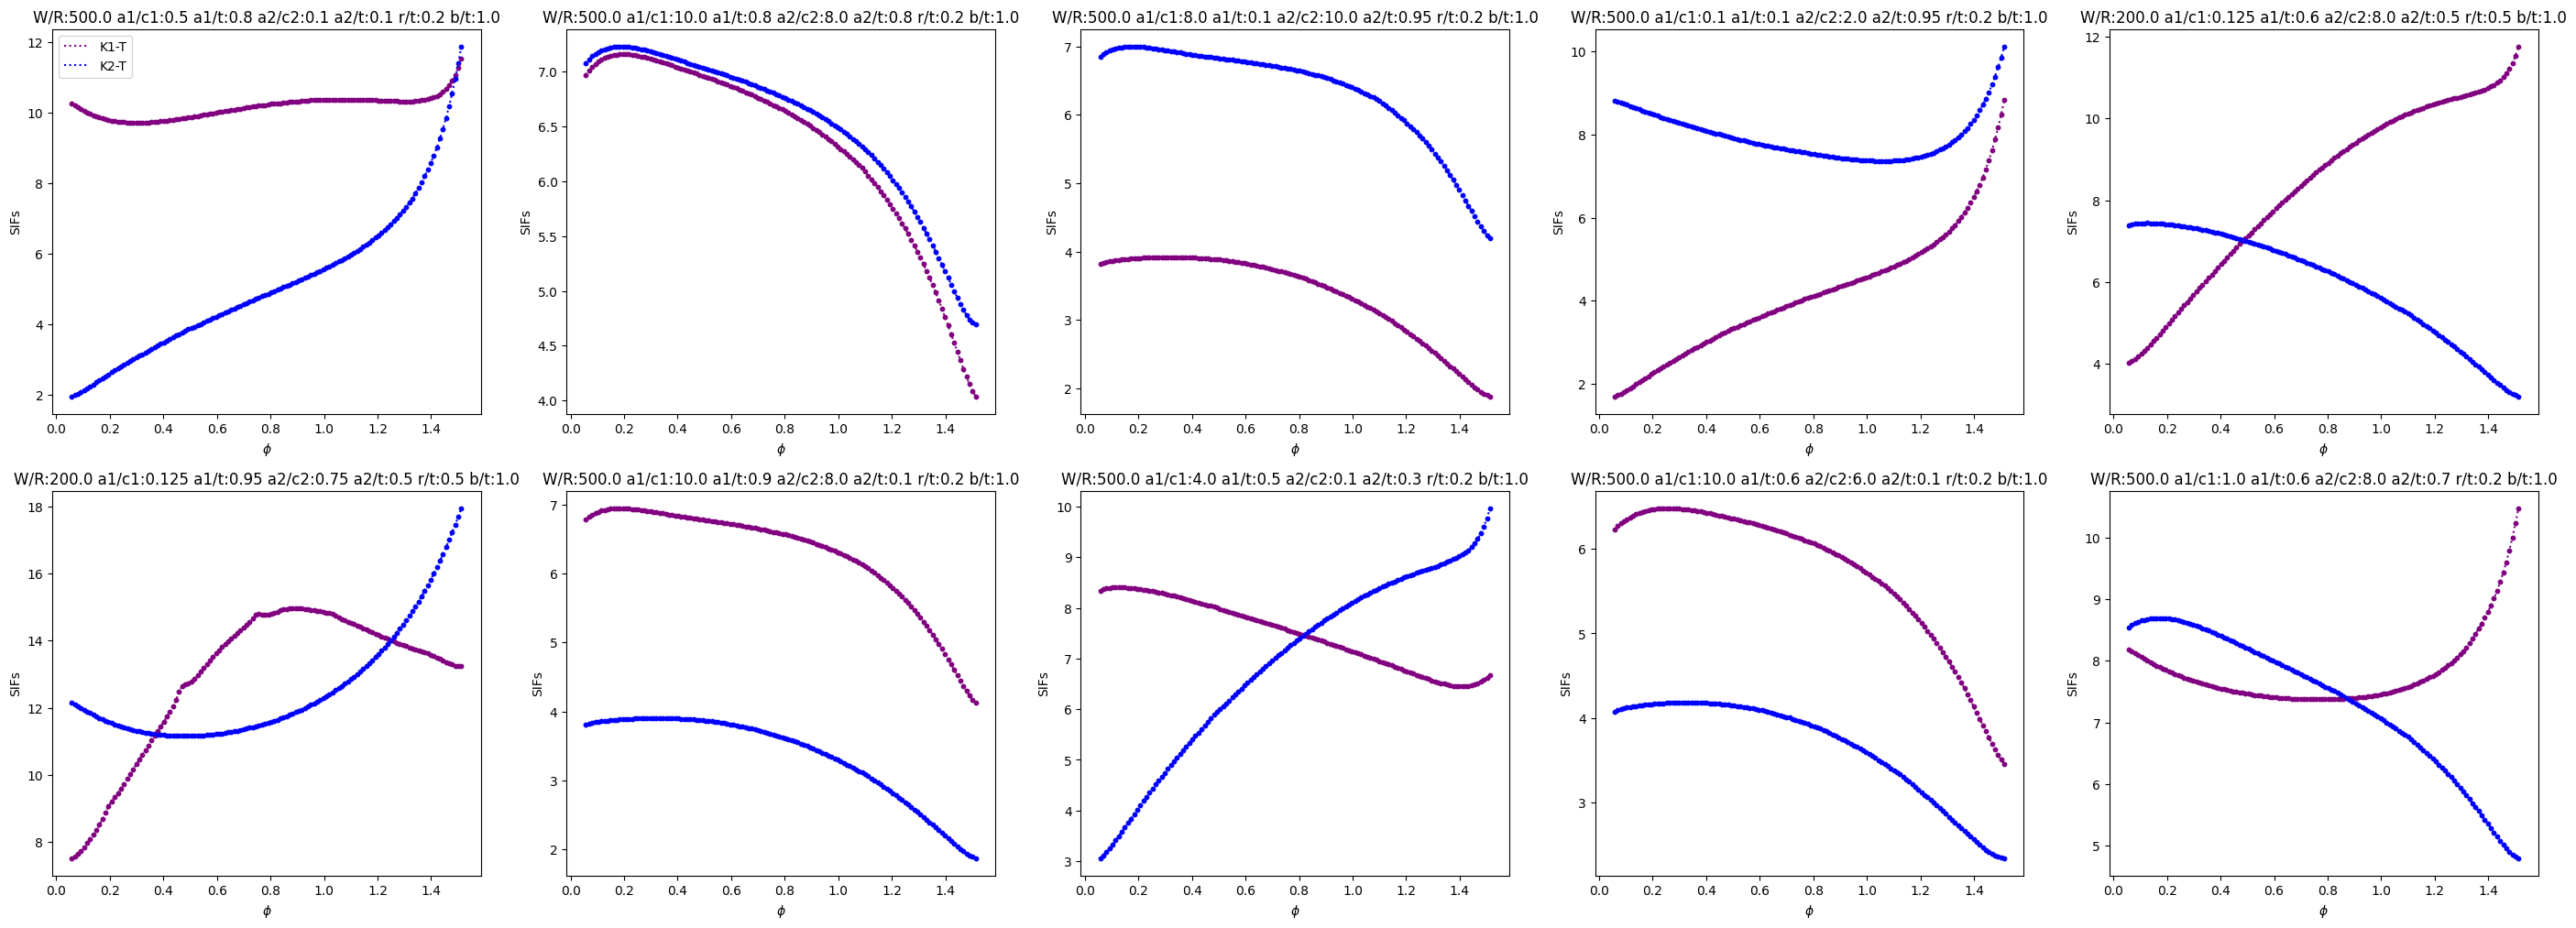

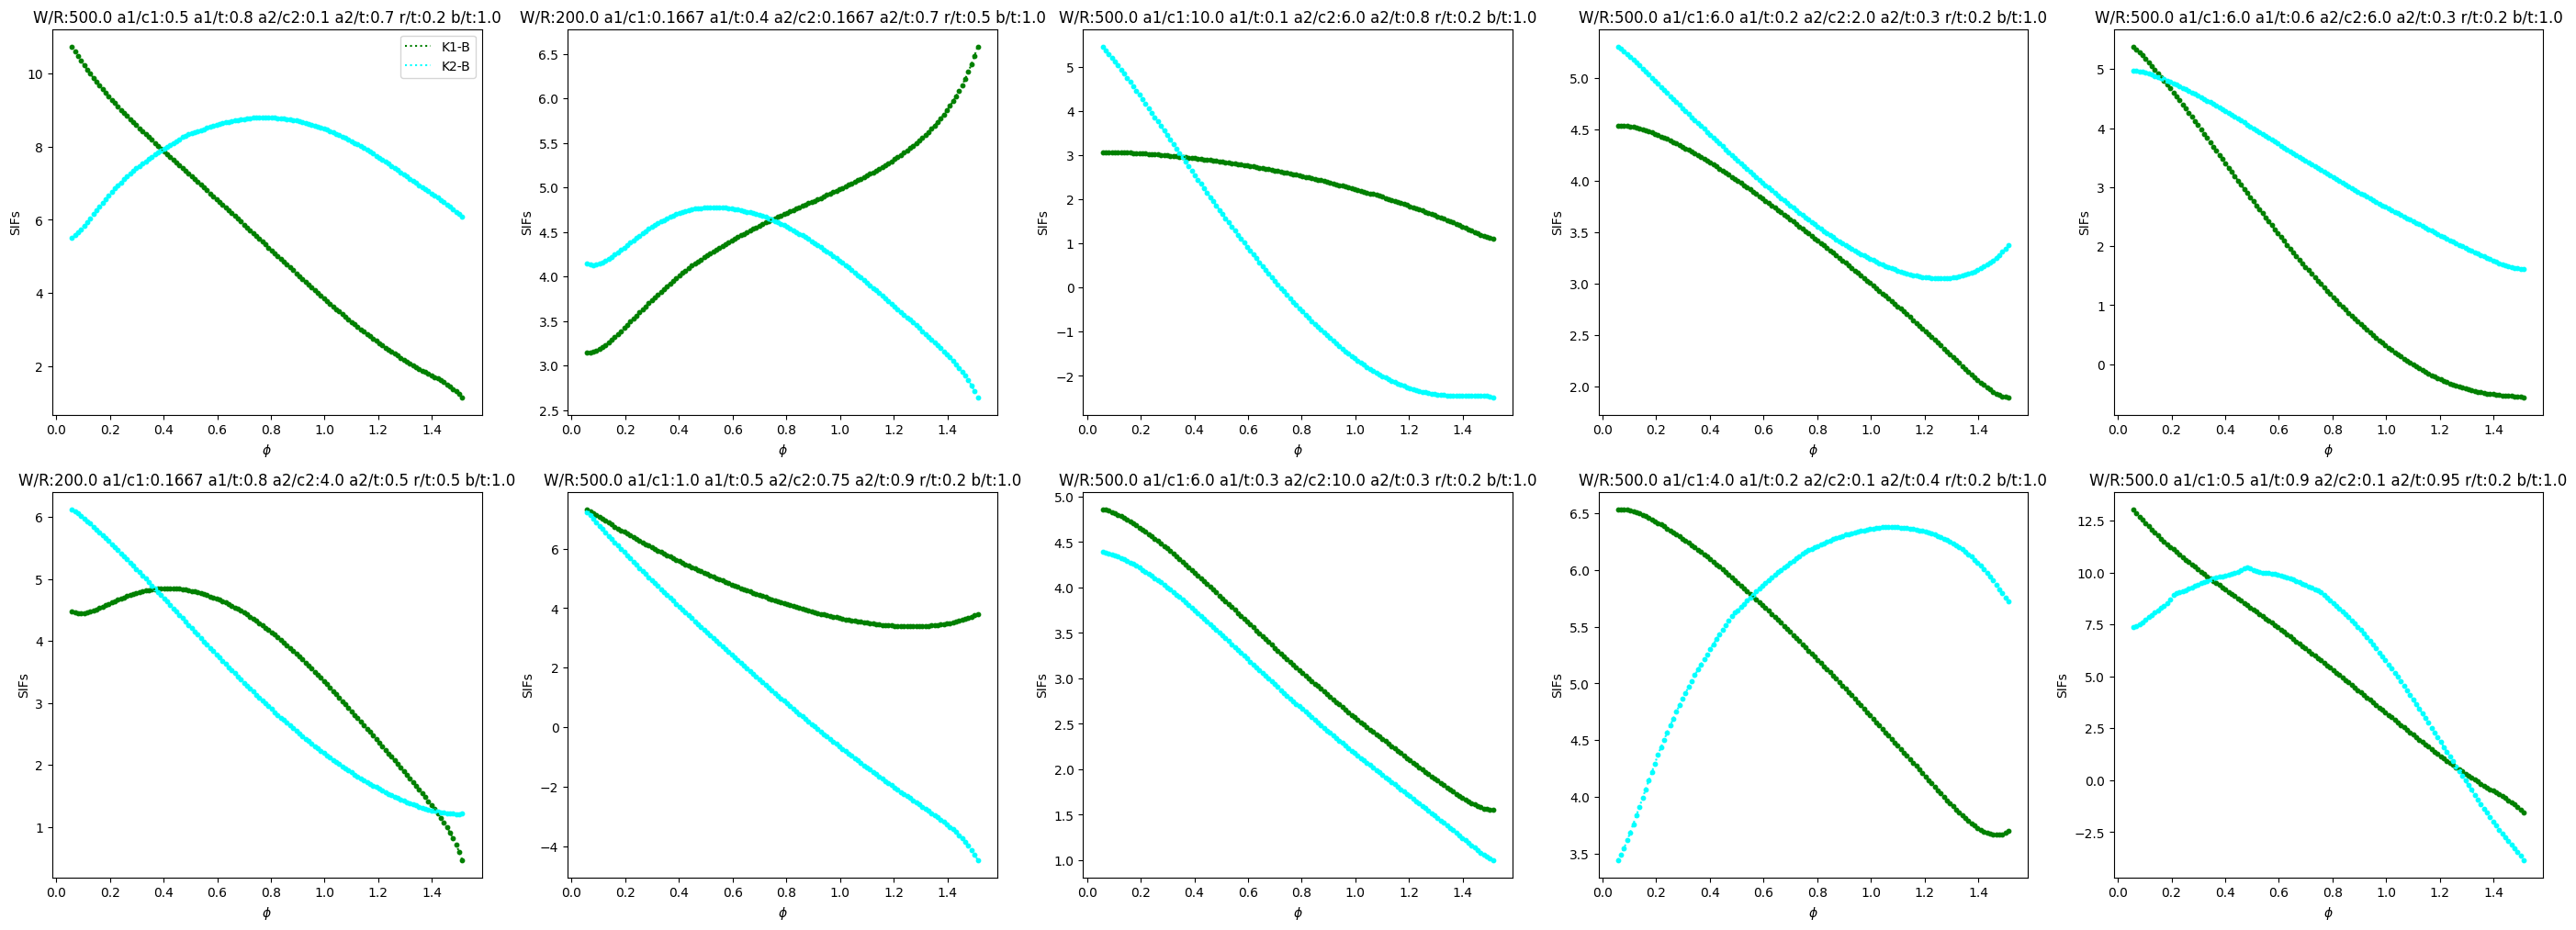

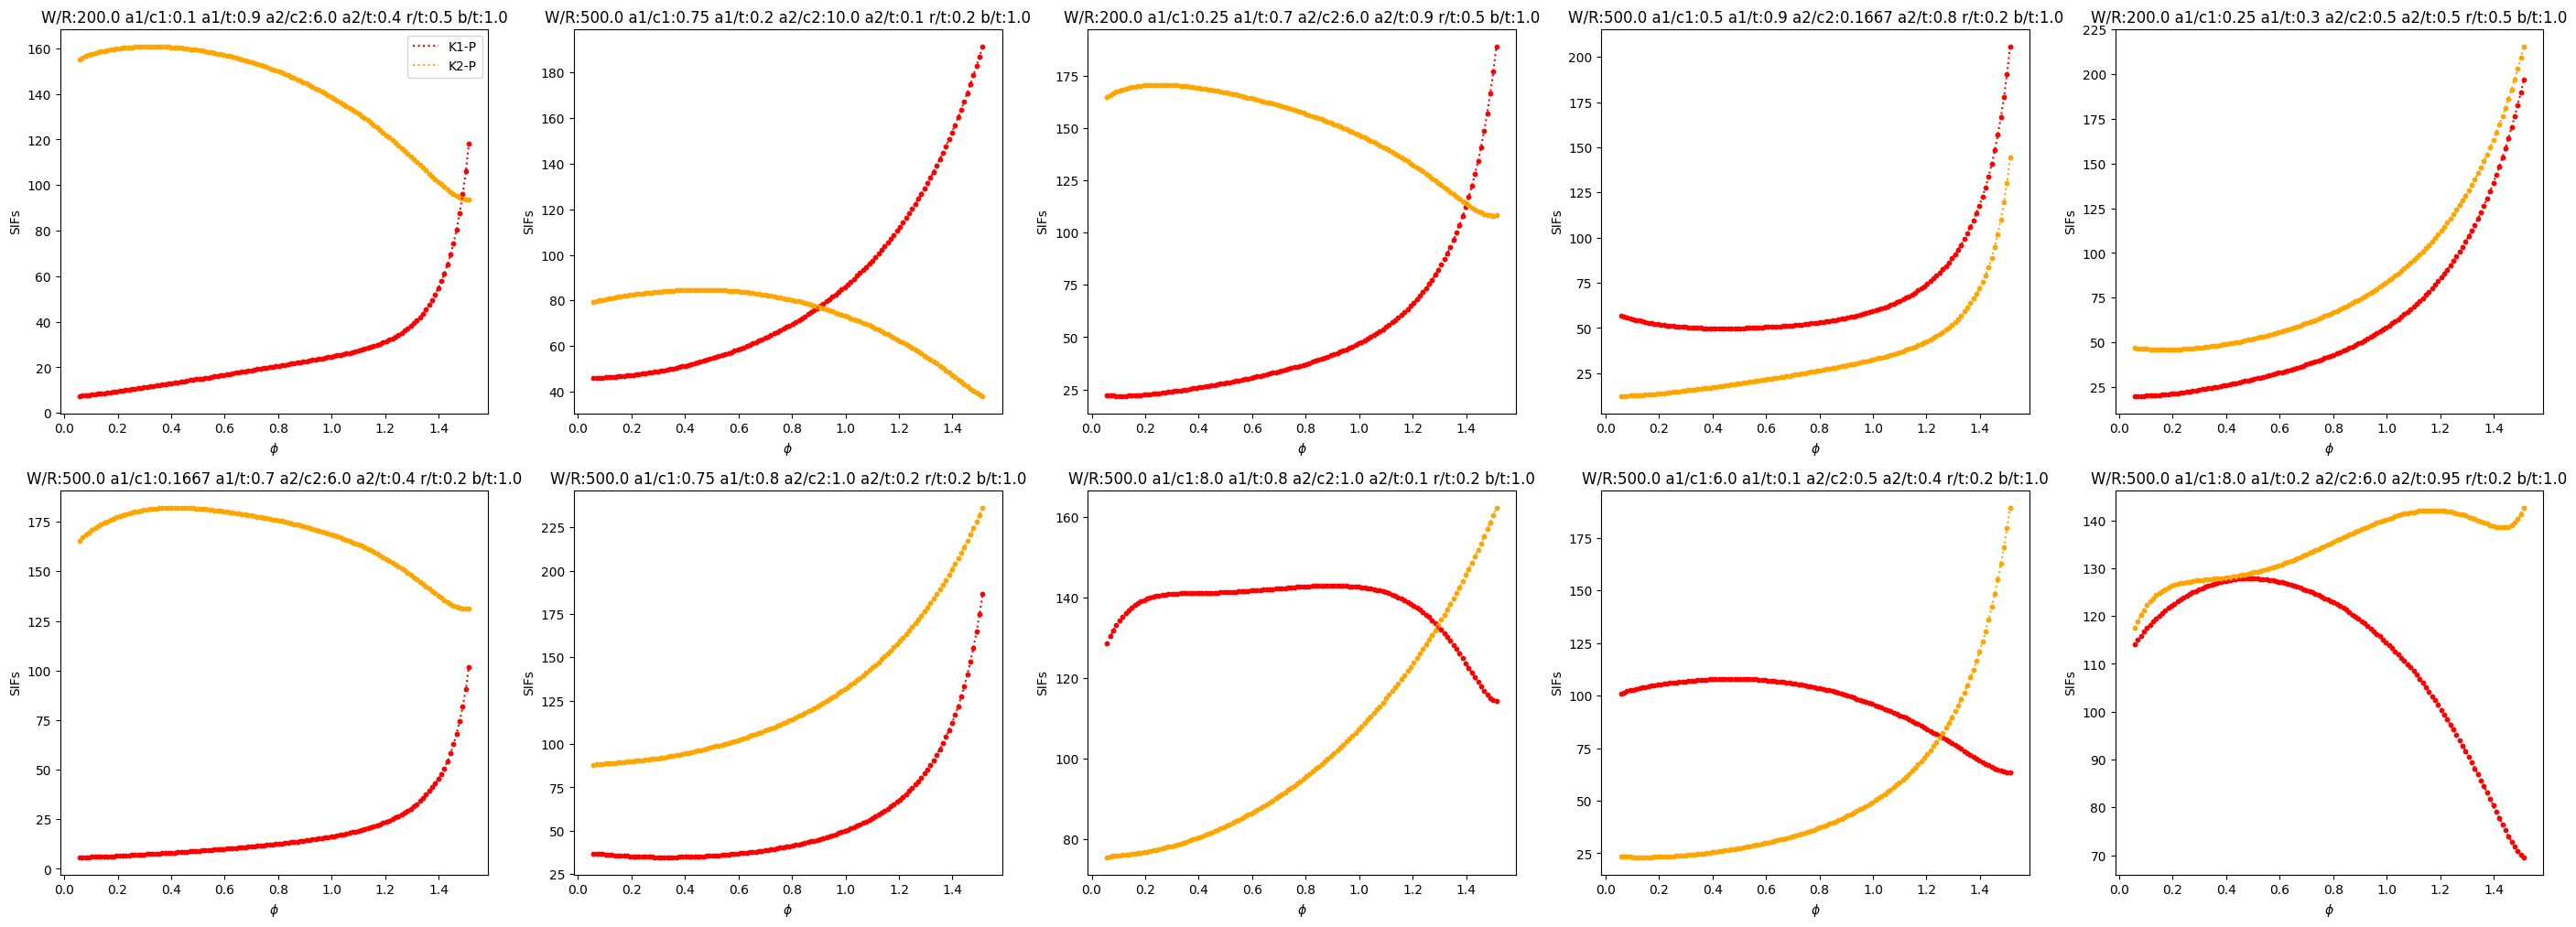

Total scenarios:  19346


In [26]:
d = df.to_numpy()

num_crack = np.unique(d[:,0])

np.random.seed(100)
fig, axs = plt.subplots(2, 5, figsize=(35,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(num_crack))
        data = d[idx*128:idx*128+128]
        W_R = np.unique(data[:,1])
        a1_c1 = np.unique(data[:,2])
        a1_t = np.unique(data[:,3])
        a2_c2 = np.unique(data[:,4])
        a2_t = np.unique(data[:,5])
        r_t = np.unique(data[:,6])
        b_t = np.unique(data[:,7])

        assert len(W_R) == 1
        assert len(a1_c1) == 1
        assert len(a1_t) == 1
        assert len(a2_c2) == 1
        assert len(a2_t) == 1
        assert len(r_t) == 1
        assert len(b_t) == 1

        axs[i,j].scatter(data[:,-8], data[:,-6], color='purple', s=10)
        axs[i,j].plot(data[:,-8], data[:,-6], label="K1-T", color='purple', linestyle=":")

        axs[i,j].scatter(data[:,-7], data[:,-5], color='blue', s=10)
        axs[i,j].plot(data[:,-7], data[:,-5], label="K2-T", color='blue', linestyle=":")

        axs[i,j].set_title("W/R:{} a1/c1:{} a1/t:{} a2/c2:{} a2/t:{} r/t:{} b/t:{}".format(W_R[0], a1_c1[0], a1_t[0], a2_c2[0], a2_t[0], r_t[0], b_t[0]))
        axs[i,j].set_ylabel("SIFs")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()


fig, axs = plt.subplots(2, 5, figsize=(35,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(num_crack))
        data = d[idx*128:idx*128+128]
        W_R = np.unique(data[:,1])
        a1_c1 = np.unique(data[:,2])
        a1_t = np.unique(data[:,3])
        a2_c2 = np.unique(data[:,4])
        a2_t = np.unique(data[:,5])
        r_t = np.unique(data[:,6])
        b_t = np.unique(data[:,7])

        assert len(W_R) == 1
        assert len(a1_c1) == 1
        assert len(a1_t) == 1
        assert len(a2_c2) == 1
        assert len(a2_t) == 1
        assert len(r_t) == 1
        assert len(b_t) == 1

        axs[i,j].scatter(data[:,-8], data[:,-4], color='green', s=10)
        axs[i,j].plot(data[:,-8], data[:,-4], label="K1-B", color='green', linestyle=":")

        axs[i,j].scatter(data[:,-7], data[:,-3], color='cyan', s=10)
        axs[i,j].plot(data[:,-7], data[:,-3], label="K2-B", color='cyan', linestyle=":")

        axs[i,j].set_title("W/R:{} a1/c1:{} a1/t:{} a2/c2:{} a2/t:{} r/t:{} b/t:{}".format(W_R[0], a1_c1[0], a1_t[0], a2_c2[0], a2_t[0], r_t[0], b_t[0]))
        axs[i,j].set_ylabel("SIFs")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

fig, axs = plt.subplots(2, 5, figsize=(35,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(num_crack))
        data = d[idx*128:idx*128+128]
        W_R = np.unique(data[:,1])
        a1_c1 = np.unique(data[:,2])
        a1_t = np.unique(data[:,3])
        a2_c2 = np.unique(data[:,4])
        a2_t = np.unique(data[:,5])
        r_t = np.unique(data[:,6])
        b_t = np.unique(data[:,7])

        assert len(W_R) == 1
        assert len(a1_c1) == 1
        assert len(a1_t) == 1
        assert len(a2_c2) == 1
        assert len(a2_t) == 1
        assert len(r_t) == 1
        assert len(b_t) == 1

        axs[i,j].scatter(data[:,-8], data[:,-2], color='red', s=10)
        axs[i,j].plot(data[:,-8], data[:,-2], label="K1-P", color='red', linestyle=":")

        axs[i,j].scatter(data[:,-7], data[:,-1], color='orange', s=10)
        axs[i,j].plot(data[:,-7], data[:,-1], label="K2-P", color='orange', linestyle=":")

        axs[i,j].set_title("W/R:{} a1/c1:{} a1/t:{} a2/c2:{} a2/t:{} r/t:{} b/t:{}".format(W_R[0], a1_c1[0], a1_t[0], a2_c2[0], a2_t[0], r_t[0], b_t[0]))
        axs[i,j].set_ylabel("SIFs")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

print("Total scenarios: ", len(num_crack))